# Bandpass Filter S-Parameter Prediction using ML Models

This notebook predicts S21 (insertion loss) and S11 (return loss) from filter parameters. It uses intelligent feature selection to handle datasets with missing stopband information.

## 1. Setup & Data Loading

In [1]:
!pip install xgboost lightgbm catboost scikit-learn pandas numpy matplotlib seaborn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
import warnings
import joblib
warnings.filterwarnings('ignore')

# Import ML models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

print("✓ All libraries imported successfully")

# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

# --- IMPORTANT: Update this path to your file location ---
file_path = '/content/drive/MyDrive/BPF_paper/cleaned_bpf_data_final.csv'

try:
    df = pd.read_csv(file_path)
    print(f"\n✓ Loaded data from: {file_path}")
    print(f"Dataset shape: {df.shape}")
    print("\nFirst few rows:")
    print(df.head())
except FileNotFoundError:
    print(f"❌ ERROR: File not found at {file_path}")
    print("Please upload your 'cleaned_bpf_data_final.csv' file to Google Drive and update the path.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.4 MB/s eta 0:00:00
✓ All libraries imported successfully
Mounted at /content/drive

✓ Loaded data from: /content/drive/MyDrive/BPF_paper/cleaned_bpf_data_final.csv
Dataset shape: (1170234, 40)

First few rows:
       model                                                url    category  \
0  ABF-3R3G+  https://www.minicircuits.com/WebStore/dashboar...  RF Filters   
1  ABF-3R3G+  https://www.minicircuits.com/WebStore/dashboar...  RF Filters   
2  ABF-3R3G+  https://www.minicircuits.com/WebStore/dashboar...  RF Filters   
3  ABF-3R3G+  https://www.minicircuits.com/WebStore/dashboar...  RF Filters   
4  ABF-3R3G+  https://www.minicircuits.com/WebStore/dashboar...  RF Filters   

   Model Number                      Case Style  Description  \
0           NaN  ZH3433 LxWxH 0.472x0.472x0.100          NaN   
1           NaN  ZH3433 LxWxH 0.472x0.472x0.100          NaN   
2           NaN  ZH3433 LxWxH 0.472x0.472x0.100          NaN   


## 2. Smart Feature Engineering & Imputation

In [2]:
df_processed = df.copy()

print("="*60)
print("DATA PREPROCESSING & FEATURE ENGINEERING")
print("="*60)

# STEP 1: Calculate core features (always available from passband)
print("\n--- Calculating core passband features ---")
df_processed['f_center'] = (df_processed['Passband F1 (MHz)'] + df_processed['Passband F2 (MHz)']) / 2
df_processed['BW'] = df_processed['Passband F2 (MHz)'] - df_processed['Passband F1 (MHz)']
df_processed['frac_BW'] = df_processed['BW'] / df_processed['f_center']
df_processed['Q_approx'] = df_processed['f_center'] / df_processed['BW']
df_processed['log_f_center'] = np.log10(df_processed['f_center'] * 1e6)
print("✓ Calculated core passband features (f_center, BW, etc.)")

# STEP 2: Calculate stopband features ONLY where data exists
print("\n--- Calculating stopband features (where available) ---")
df_processed['stop_offset1'] = df_processed['Passband F1 (MHz)'] - df_processed['Stopband F3 (MHz)']
df_processed['stop_offset2'] = df_processed['Stopband F4 (MHz)'] - df_processed['Passband F2 (MHz)']
df_processed['F3_norm'] = df_processed['Stopband F3 (MHz)'] / df_processed['f_center']

freq_diff1 = df_processed['Passband F1 (MHz)'] - df_processed['Stopband F3 (MHz)']
df_processed['slope1'] = df_processed['Rejection @ F3 (dB)'] / freq_diff1.replace(0, np.nan)

freq_diff2 = df_processed['Stopband F4 (MHz)'] - df_processed['Passband F2 (MHz)']
df_processed['slope2'] = df_processed['Rejection @ F4 (dB)'] / freq_diff2.replace(0, np.nan)

rejections = df_processed[['Rejection @ F3 (dB)', 'Rejection @ F4 (dB)']]
df_processed['min_rejection'] = rejections.min(axis=1)
df_processed['max_rejection'] = rejections.max(axis=1)
df_processed['rej_diff'] = df_processed['max_rejection'] - df_processed['min_rejection']
print("✓ Calculated conditional stopband features (slopes, offsets, etc.)")

# STEP 3: Smart feature selection based on data availability
print("\n--- Smart feature selection ---")
core_features = ['Passband F1 (MHz)', 'Passband F2 (MHz)', 'frequency_hz', 'f_center', 'BW', 'frac_BW', 'Q_approx', 'log_f_center']
stopband_features = ['Stopband F3 (MHz)', 'Stopband F4 (MHz)', 'Rejection @ F3 (dB)', 'Rejection @ F4 (dB)', 'stop_offset1', 'stop_offset2', 'slope1', 'slope2', 'min_rejection', 'max_rejection', 'rej_diff', 'F3_norm']
other_features = ['z0_ohm']

potential_features = core_features + stopband_features + other_features
selected_features = []
for feat in potential_features:
    if feat in df_processed.columns:
        missing_pct = df_processed[feat].isnull().sum() / len(df_processed) * 100
        if missing_pct < 90: # Only include features with at least 10% valid data
            selected_features.append(feat)
            print(f"  ✓ Including '{feat}': {100-missing_pct:.1f}% complete")

print(f"\n✓ Selected {len(selected_features)} features for modeling.")

# STEP 4: Final processing: drop rows without targets and impute features
print("\n--- Applying median imputation to selected features ---")
required_cols = selected_features + ['s21_db', 's11_db']
df_model_ready = df_processed[required_cols].dropna(subset=['s21_db', 's11_db'])

X = df_model_ready[selected_features]
y_s21 = df_model_ready['s21_db']
y_s11 = df_model_ready['s11_db']

imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=selected_features, index=X.index)
print(f"✓ Data ready for training: {len(X_imputed):,} samples")

# STEP 5: Train/Test Split & Scaling
X_train, X_test, y_s21_train, y_s21_test = train_test_split(X_imputed, y_s21, test_size=0.2, random_state=42)
_, _, y_s11_train, y_s11_test = train_test_split(X_imputed, y_s11, test_size=0.2, random_state=42) # Use same split indices

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"✓ Data split and scaled. Training set: {len(X_train_scaled):,} samples.")

DATA PREPROCESSING & FEATURE ENGINEERING

--- Calculating core passband features ---
✓ Calculated core passband features (f_center, BW, etc.)

--- Calculating stopband features (where available) ---
✓ Calculated conditional stopband features (slopes, offsets, etc.)

--- Smart feature selection ---
  ✓ Including 'Passband F1 (MHz)': 100.0% complete
  ✓ Including 'Passband F2 (MHz)': 100.0% complete
  ✓ Including 'frequency_hz': 100.0% complete
  ✓ Including 'f_center': 100.0% complete
  ✓ Including 'BW': 100.0% complete
  ✓ Including 'frac_BW': 100.0% complete
  ✓ Including 'Q_approx': 100.0% complete
  ✓ Including 'log_f_center': 100.0% complete
  ✓ Including 'Stopband F3 (MHz)': 14.4% complete
  ✓ Including 'Stopband F4 (MHz)': 14.3% complete
  ✓ Including 'Rejection @ F3 (dB)': 100.0% complete
  ✓ Including 'Rejection @ F4 (dB)': 100.0% complete
  ✓ Including 'stop_offset1': 14.4% complete
  ✓ Including 'stop_offset2': 14.3% complete
  ✓ Including 'slope1': 14.4% complete
  ✓ Includi

## 3. Model Training & Evaluation

**FIX APPLIED HERE:** A function `get_models()` is now used to generate a fresh set of model instances for each target variable (S21 and S11). This prevents the S11 training from overwriting the S21 model weights.

In [3]:
def get_models():
    """Returns a dictionary of fresh, untrained model instances."""
    n_est = 150 # Number of estimators for tree-based models
    return {
        'XGBoost': XGBRegressor(n_estimators=n_est, random_state=42, n_jobs=-1, verbosity=0, max_depth=8),
        'LightGBM': LGBMRegressor(n_estimators=n_est, random_state=42, verbose=-1, max_depth=8),
        'CatBoost': CatBoostRegressor(iterations=n_est, random_state=42, verbose=0, depth=8)
    }

def train_evaluate(model, name, X_tr, X_te, y_tr, y_te):
    """Trains a model and returns its performance metrics and predictions."""
    print(f"  Training {name}...", end=' ')
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    metrics = {
        'model': model,
        'name': name,
        'predictions': y_pred,
        'rmse': np.sqrt(mean_squared_error(y_te, y_pred)),
        'mae': mean_absolute_error(y_te, y_pred),
        'r2': r2_score(y_te, y_pred)
    }
    print(f"R²={metrics['r2']:.4f}, RMSE={metrics['rmse']:.4f}")
    return metrics

# --- Train models for S21 ---
print("\n" + "="*60)
print("PREDICTING S21 (INSERTION LOSS)")
print("="*60)
models_for_s21 = get_models()
results_s21 = {name: train_evaluate(
    model, name, X_train_scaled, X_test_scaled, y_s21_train, y_s21_test
) for name, model in models_for_s21.items()}

# --- Train separate, fresh models for S11 ---
print("\n" + "="*60)
print("PREDICTING S11 (RETURN LOSS)")
print("="*60)
models_for_s11 = get_models()
results_s11 = {name: train_evaluate(
    model, name, X_train_scaled, X_test_scaled, y_s11_train, y_s11_test
) for name, model in models_for_s11.items()}



PREDICTING S21 (INSERTION LOSS)
  Training XGBoost... R²=0.9601, RMSE=6.4398
  Training LightGBM... R²=0.7305, RMSE=16.7454
  Training CatBoost... R²=0.8800, RMSE=11.1745

PREDICTING S11 (RETURN LOSS)
  Training XGBoost... R²=0.8913, RMSE=2.9855
  Training LightGBM... R²=0.6256, RMSE=5.5414
  Training CatBoost... R²=0.7811, RMSE=4.2375


## 4. Results Comparison & Visualization


FINAL RESULTS

S21 (Insertion Loss) Model Comparison:
   Model       R²      RMSE       MAE
 XGBoost 0.960145  6.439811  4.277331
CatBoost 0.879996 11.174483  8.198647
LightGBM 0.730517 16.745357 13.098942

S11 (Return Loss) Model Comparison:
   Model       R²     RMSE      MAE
 XGBoost 0.891331 2.985545 1.471180
CatBoost 0.781081 4.237522 2.609805
LightGBM 0.625638 5.541355 3.557682

✓ Best model for S21: XGBoost (R²=0.9601)
✓ Best model for S11: XGBoost (R²=0.8913)

FEATURE IMPORTANCE (Top 10 for S21 - XGBoost)
            Feature  Importance
      min_rejection    0.304365
      max_rejection    0.105697
           f_center    0.078383
  Passband F2 (MHz)    0.058891
                 BW    0.055369
  Passband F1 (MHz)    0.054477
Rejection @ F4 (dB)    0.047791
            frac_BW    0.045018
           Q_approx    0.035147
Rejection @ F3 (dB)    0.029418


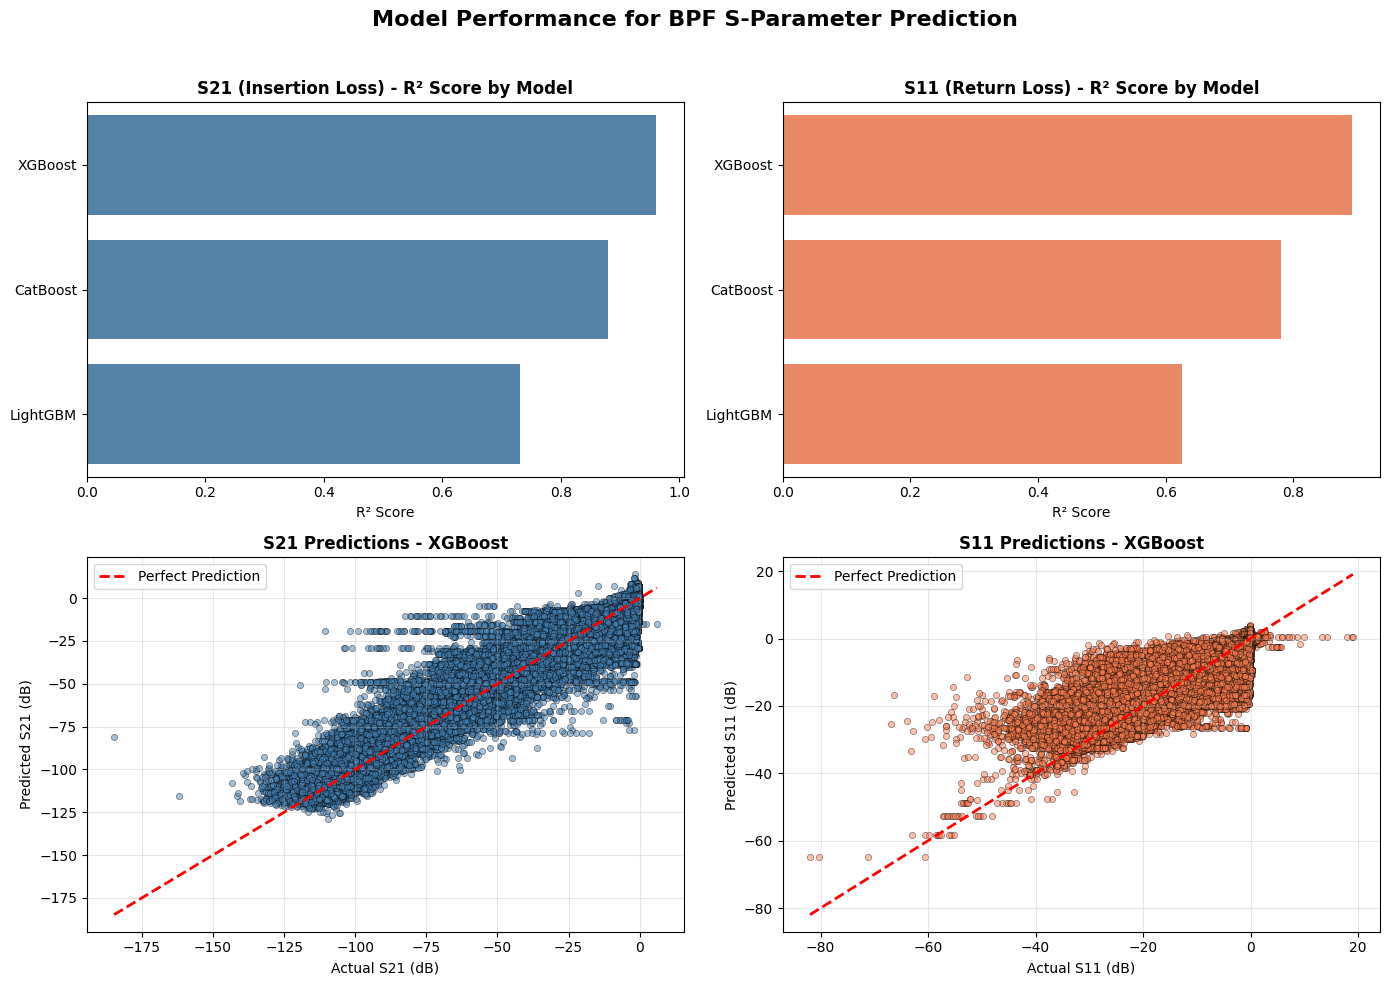

In [4]:
# --- Create comparison dataframes ---
comp_s21 = pd.DataFrame([{'Model': r['name'], 'R²': r['r2'], 'RMSE': r['rmse'], 'MAE': r['mae']} for r in results_s21.values()]).sort_values('R²', ascending=False)
comp_s11 = pd.DataFrame([{'Model': r['name'], 'R²': r['r2'], 'RMSE': r['rmse'], 'MAE': r['mae']} for r in results_s11.values()]).sort_values('R²', ascending=False)

print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print("\nS21 (Insertion Loss) Model Comparison:")
print(comp_s21.to_string(index=False))
print("\nS11 (Return Loss) Model Comparison:")
print(comp_s11.to_string(index=False))

best_s21_name = comp_s21.iloc[0]['Model']
best_s11_name = comp_s11.iloc[0]['Model']
print(f"\n✓ Best model for S21: {best_s21_name} (R²={comp_s21.iloc[0]['R²']:.4f})")
print(f"✓ Best model for S11: {best_s11_name} (R²={comp_s11.iloc[0]['R²']:.4f})")

# --- Feature Importance of the Best S21 Model ---
print("\n" + "="*60)
print(f"FEATURE IMPORTANCE (Top 10 for S21 - {best_s21_name})")
print("="*60)
best_model_s21_obj = results_s21[best_s21_name]['model']
if hasattr(best_model_s21_obj, 'feature_importances_'):
    feat_imp = pd.DataFrame({'Feature': selected_features, 'Importance': best_model_s21_obj.feature_importances_}).sort_values('Importance', ascending=False).head(10)
    print(feat_imp.to_string(index=False))

# --- Visualizations ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance for BPF S-Parameter Prediction', fontsize=16, fontweight='bold')

sns.barplot(x='R²', y='Model', data=comp_s21, ax=axes[0, 0], color='steelblue')
axes[0,0].set_title('S21 (Insertion Loss) - R² Score by Model', fontweight='bold')
axes[0,0].set_xlabel('R² Score')
axes[0,0].set_ylabel('')

sns.barplot(x='R²', y='Model', data=comp_s11, ax=axes[0, 1], color='coral')
axes[0,1].set_title('S11 (Return Loss) - R² Score by Model', fontweight='bold')
axes[0,1].set_xlabel('R² Score')
axes[0,1].set_ylabel('')

axes[1,0].scatter(y_s21_test, results_s21[best_s21_name]['predictions'], alpha=0.5, s=20, color='steelblue', edgecolors='k', linewidth=0.5)
axes[1,0].plot([y_s21_test.min(), y_s21_test.max()], [y_s21_test.min(), y_s21_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1,0].set_xlabel('Actual S21 (dB)')
axes[1,0].set_ylabel('Predicted S21 (dB)')
axes[1,0].set_title(f'S21 Predictions - {best_s21_name}', fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

axes[1,1].scatter(y_s11_test, results_s11[best_s11_name]['predictions'], alpha=0.5, s=20, color='coral', edgecolors='k', linewidth=0.5)
axes[1,1].plot([y_s11_test.min(), y_s11_test.max()], [y_s11_test.min(), y_s11_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1,1].set_xlabel('Actual S11 (dB)')
axes[1,1].set_ylabel('Predicted S11 (dB)')
axes[1,1].set_title(f'S11 Predictions - {best_s11_name}', fontweight='bold')
axes[1,1].legend()
axes[1,1].grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## 5. Export Models & Artifacts for Inference

In [5]:
output_dir = '/content/drive/MyDrive/'

print("="*60)
print("SAVING MODELS & ARTIFACTS FOR LATER USE")
print("="*60)

# Retrieve the best trained model objects
s21_model_to_save = results_s21[best_s21_name]['model']
s11_model_to_save = results_s11[best_s11_name]['model']

# Define file paths
s21_model_path = f'{output_dir}bpf_s21_model.pkl'
s11_model_path = f'{output_dir}bpf_s11_model.pkl'
scaler_path = f'{output_dir}bpf_scaler.pkl'
imputer_path = f'{output_dir}bpf_imputer.pkl'
features_path = f'{output_dir}bpf_features.joblib'

# Save the Python objects to disk
joblib.dump(s21_model_to_save, s21_model_path)
joblib.dump(s11_model_to_save, s11_model_path)
joblib.dump(scaler, scaler_path)
joblib.dump(imputer, imputer_path)
joblib.dump(selected_features, features_path)

print(f"✓ Best S21 Model ({best_s21_name}) saved to: {s21_model_path}")
print(f"✓ Best S11 Model ({best_s11_name}) saved to: {s11_model_path}")
print(f"✓ Scaler object saved to: {scaler_path}")
print(f"✓ Imputer object saved to: {imputer_path}")
print(f"✓ Feature list saved to: {features_path}")

SAVING MODELS & ARTIFACTS FOR LATER USE
✓ Best S21 Model (XGBoost) saved to: /content/drive/MyDrive/bpf_s21_model.pkl
✓ Best S11 Model (XGBoost) saved to: /content/drive/MyDrive/bpf_s11_model.pkl
✓ Scaler object saved to: /content/drive/MyDrive/bpf_scaler.pkl
✓ Imputer object saved to: /content/drive/MyDrive/bpf_imputer.pkl
✓ Feature list saved to: /content/drive/MyDrive/bpf_features.joblib


## 6. Inference Class & Testing

This class loads the saved model files and provides a simple `predict` method to get S21 and S11 values for new filter parameters.

In [6]:
class BPFPredictor:
    """
    A class to load BPF models and artifacts and make predictions.
    """
    def __init__(self, model_dir='/content/drive/MyDrive/'):
        """
        Loads the saved models and artifacts upon initialization.
        """
        try:
            self.s21_model = joblib.load(f'{model_dir}bpf_s21_model.pkl')
            self.s11_model = joblib.load(f'{model_dir}bpf_s11_model.pkl')
            self.scaler = joblib.load(f'{model_dir}bpf_scaler.pkl')
            self.imputer = joblib.load(f'{model_dir}bpf_imputer.pkl')
            self.features = joblib.load(f'{model_dir}bpf_features.joblib')
            print("✅ Predictor initialized successfully.")
            print(f"Models expect {len(self.features)} features.")
        except FileNotFoundError as e:
            print(f"❌ Error initializing predictor: {e}")
            print("Please ensure the model saving step was run and files are in the correct directory.")
            self.s21_model = None # Prevent further errors

    def _create_feature_dataframe(self, data_dict):
        """Creates a dataframe with features in the correct order."""
        # Create a dictionary with all expected features, defaulting to np.nan
        template_dict = {feature: np.nan for feature in self.features}
        # Update the template with the provided data
        template_dict.update(data_dict)
        # Create a single-row DataFrame
        return pd.DataFrame([template_dict], columns=self.features)

    def predict(self, frequency_hz, f1_mhz, f2_mhz, z0_ohm=50,
                f3_mhz=None, rej_f3_db=None,
                f4_mhz=None, rej_f4_db=None):
        """
        Predicts S21 and S11 for a bandpass filter at a given frequency.
        """
        if not self.s21_model:
             return {"Error": "Predictor not initialized."}

        # --- 1. Replicate Feature Engineering ---
        input_data = {}
        input_data['Passband F1 (MHz)'] = f1_mhz
        input_data['Passband F2 (MHz)'] = f2_mhz
        input_data['frequency_hz'] = frequency_hz
        input_data['z0_ohm'] = z0_ohm
        input_data['Stopband F3 (MHz)'] = f3_mhz
        input_data['Rejection @ F3 (dB)'] = rej_f3_db
        input_data['Stopband F4 (MHz)'] = f4_mhz
        input_data['Rejection @ F4 (dB)'] = rej_f4_db

        f_center = (f1_mhz + f2_mhz) / 2
        bw = f2_mhz - f1_mhz
        input_data['f_center'] = f_center
        input_data['BW'] = bw
        input_data['frac_BW'] = bw / f_center if f_center != 0 else np.nan
        input_data['Q_approx'] = f_center / bw if bw != 0 else np.nan
        input_data['log_f_center'] = np.log10(f_center * 1e6) if f_center > 0 else np.nan

        input_data['stop_offset1'] = f1_mhz - f3_mhz if f3_mhz is not None else np.nan
        input_data['stop_offset2'] = f4_mhz - f2_mhz if f4_mhz is not None else np.nan
        input_data['F3_norm'] = f3_mhz / f_center if f3_mhz is not None and f_center != 0 else np.nan

        freq_diff1 = f1_mhz - f3_mhz if f3_mhz is not None else np.nan
        input_data['slope1'] = rej_f3_db / freq_diff1 if rej_f3_db is not None and not np.isnan(freq_diff1) and freq_diff1 != 0 else np.nan

        freq_diff2 = f4_mhz - f2_mhz if f4_mhz is not None else np.nan
        input_data['slope2'] = rej_f4_db / freq_diff2 if rej_f4_db is not None and not np.isnan(freq_diff2) and freq_diff2 != 0 else np.nan

        rejections = [r for r in [rej_f3_db, rej_f4_db] if r is not None]
        input_data['min_rejection'] = min(rejections) if rejections else np.nan
        input_data['max_rejection'] = max(rejections) if rejections else np.nan
        input_data['rej_diff'] = input_data['max_rejection'] - input_data['min_rejection'] if rejections and len(rejections) > 1 else np.nan

        # --- 2. Format, Impute, and Scale ---
        input_df = self._create_feature_dataframe(input_data)
        input_imputed = self.imputer.transform(input_df)
        input_scaled = self.scaler.transform(input_imputed)

        # --- 3. Predict ---
        predicted_s21 = self.s21_model.predict(input_scaled)[0]
        predicted_s11 = self.s11_model.predict(input_scaled)[0]

        return {
            'Predicted S21 (dB)': f"{predicted_s21:.4f}",
            'Predicted S11 (dB)': f"{predicted_s11:.4f}"
        }

# --- Create an instance of the predictor ---
predictor = BPFPredictor(model_dir='/content/drive/MyDrive/')

# --- EXAMPLE 1: Prediction for a point within the passband ---
prediction_in_passband = predictor.predict(
    frequency_hz=3300e6,
    f1_mhz=3100,
    f2_mhz=3500
)
print("\n--- Prediction (In-Passband) ---")
print(prediction_in_passband)

# --- EXAMPLE 2: Prediction for a point outside the passband ---
prediction_out_of_band = predictor.predict(
    frequency_hz=5000e6,
    f1_mhz=3100,
    f2_mhz=3500,
    f3_mhz=2000,
    rej_f3_db=40,
    f4_mhz=4500,
    rej_f4_db=45
)
print("\n--- Prediction (Out-of-Band with Stopband Data) ---")
print(prediction_out_of_band)

✅ Predictor initialized successfully.
Models expect 21 features.

--- Prediction (In-Passband) ---
{'Predicted S21 (dB)': '-2.6339', 'Predicted S11 (dB)': '-21.4604'}

--- Prediction (Out-of-Band with Stopband Data) ---
{'Predicted S21 (dB)': '-51.4766', 'Predicted S11 (dB)': '-2.2977'}
